房价数据列： ['location', 'm2', 'price', 'price_per_m2']
租金数据列： ['location', 'm2', 'price', 'rent_per_m2']

房价每平米异常值数量： 278
租金每平米异常值数量： 15

各地区中位数房价租金比：
  location  median_price_per_m2  median_rent_per_m2  \
0      下花园          3501.000000              11.680   
1       张北          4089.692741              11.250   
2       怀来          6441.000000              15.665   
3       桥西          5673.000000              15.665   

   median_price_to_rent_ratio  
0                  299.743151  
1                  363.528244  
2                  411.171401  
3                  362.144909  


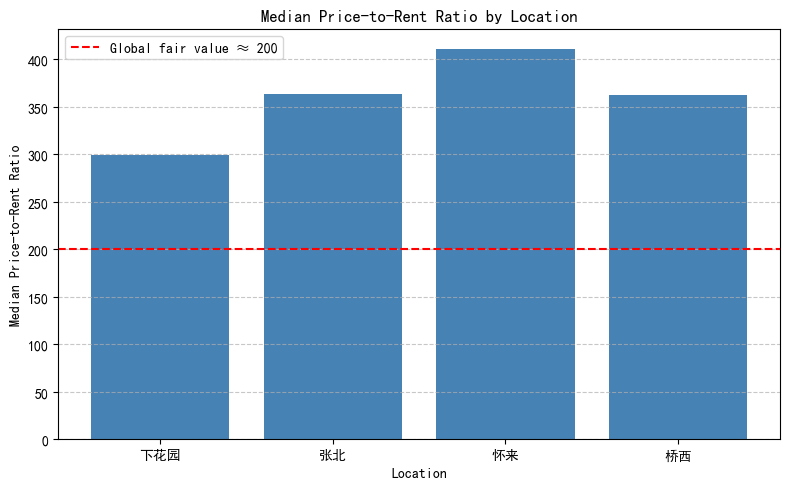

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
housing_path = r'C:\Users\Naoya\Documents\文档\Python\lecture-python-programming.notebooks-main\HW3_My_Data_My_Model\housing_price.xlsx' 
rent_path = r'C:\Users\Naoya\Documents\文档\Python\lecture-python-programming.notebooks-main\HW3_My_Data_My_Model\rent_price.xlsx'

df_price = pd.read_excel(housing_path)
df_rent = pd.read_excel(rent_path)

# 检查基本信息
print("房价数据列：", df_price.columns.tolist())
print("租金数据列：", df_rent.columns.tolist())

# 检查异常值（IQR法）
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series < lower) | (series > upper)]

print("\n房价每平米异常值数量：", len(detect_outliers(df_price['price_per_m2'])))
print("租金每平米异常值数量：", len(detect_outliers(df_rent['rent_per_m2'])))

# 各地区中位数
median_price = df_price.groupby('location')['price_per_m2'].median().reset_index()
median_price.rename(columns={'price_per_m2': 'median_price_per_m2'}, inplace=True)

median_rent = df_rent.groupby('location')['rent_per_m2'].median().reset_index()
median_rent.rename(columns={'rent_per_m2': 'median_rent_per_m2'}, inplace=True)

# 计算房价租金比（中位数相除）
df_ratio = pd.merge(median_price, median_rent, on='location', how='inner')
df_ratio['median_price_to_rent_ratio'] = df_ratio['median_price_per_m2'] / df_ratio['median_rent_per_m2']

print("\n各地区中位数房价租金比：")
print(df_ratio)

# 绘制柱状图
plt.figure(figsize=(8, 5))
plt.bar(df_ratio['location'], df_ratio['median_price_to_rent_ratio'], color='steelblue')
plt.axhline(y=200, color='r', linestyle='--', label='Global fair value ≈ 200')
plt.title('Median Price-to-Rent Ratio by Location')
plt.xlabel('Location')
plt.ylabel('Median Price-to-Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Model 1 回归结果：
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     399.0
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          3.30e-296
Time:                        17:13:49   Log-Likelihood:                -44550.
No. Observations:                4695   AIC:                         8.911e+04
Df Residuals:                    4690   BIC:                         8.914e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1713.6687    165.628  

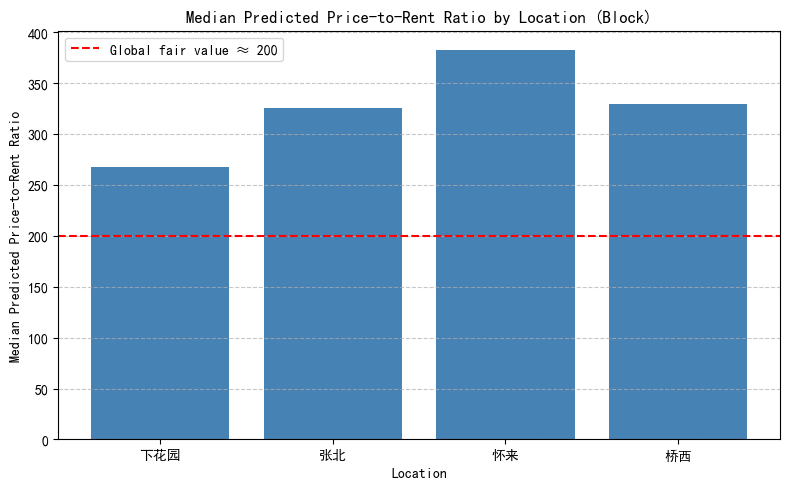

In [15]:
import statsmodels.api as sm

# 确保数值类型并删除空值
df_price['m2'] = pd.to_numeric(df_price['m2'], errors='coerce')
df_price['price_per_m2'] = pd.to_numeric(df_price['price_per_m2'], errors='coerce')
df_price = df_price.dropna(subset=['m2', 'price_per_m2', 'location'])
df_price['m2'] = df_price['m2'].astype(float)  # 保证 float 类型

df_rent['m2'] = pd.to_numeric(df_rent['m2'], errors='coerce')
df_rent['rent_per_m2'] = pd.to_numeric(df_rent['rent_per_m2'], errors='coerce')
df_rent = df_rent.dropna(subset=['m2', 'rent_per_m2', 'location'])
df_rent['m2'] = df_rent['m2'].astype(float)  # 保证 float 类型

# 建立哑变量并确保 float 类型
df_price_model = pd.get_dummies(df_price, columns=['location'], drop_first=True).astype(float)
df_rent_model = pd.get_dummies(df_rent, columns=['location'], drop_first=True).astype(float)

# --- Model 1: price_per_m2 ~ m2 + location ---
X_price = df_price_model[['m2'] + [col for col in df_price_model.columns if col.startswith('location_')]]
y_price = df_price_model['price_per_m2']
X_price = sm.add_constant(X_price)
model_price = sm.OLS(y_price, X_price).fit()
print("\nModel 1 回归结果：")
print(model_price.summary())

# 预测 price_per_m2
df_price['pred_price_per_m2'] = model_price.predict(sm.add_constant(
    df_price_model[X_price.columns[1:]]
))

# Model 2: rent_per_m2 ~ m2 + location
X_rent = df_rent_model[['m2'] + [col for col in df_rent_model.columns if col.startswith('location_')]]
y_rent = df_rent_model['rent_per_m2']
X_rent = sm.add_constant(X_rent)
model_rent = sm.OLS(y_rent, X_rent).fit()
print("\nModel 2 回归结果：")
print(model_rent.summary())

# 预测 rent_per_m2
df_rent['pred_rent_per_m2'] = model_rent.predict(sm.add_constant(
    df_rent_model[X_rent.columns[1:]]
))

# 合并预测数据，计算每条数据的 price-to-rent ratio
df_merged = pd.merge(df_price[['location', 'm2', 'pred_price_per_m2']],
                     df_rent[['location', 'm2', 'pred_rent_per_m2']],
                     on=['location', 'm2'], how='inner')

df_merged['pred_price_to_rent_ratio'] = df_merged['pred_price_per_m2'] / df_merged['pred_rent_per_m2']

# Figure B: 各小区中位数房价租金比柱状图
median_ratio_block = df_merged.groupby('location')['pred_price_to_rent_ratio'].median().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(median_ratio_block['location'], median_ratio_block['pred_price_to_rent_ratio'], color='steelblue')
plt.axhline(y=200, color='r', linestyle='--', label='Global fair value ≈ 200')
plt.title('Median Predicted Price-to-Rent Ratio by Location (Block)')
plt.xlabel('Location')
plt.ylabel('Median Predicted Price-to-Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Model 1+ 回归结果：
                            OLS Regression Results                            
Dep. Variable:           price_per_m2   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     284.7
Date:                Wed, 15 Oct 2025   Prob (F-statistic):               0.00
Time:                        17:44:52   Log-Likelihood:                -44307.
No. Observations:                4695   AIC:                         8.863e+04
Df Residuals:                    4686   BIC:                         8.869e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1795.6

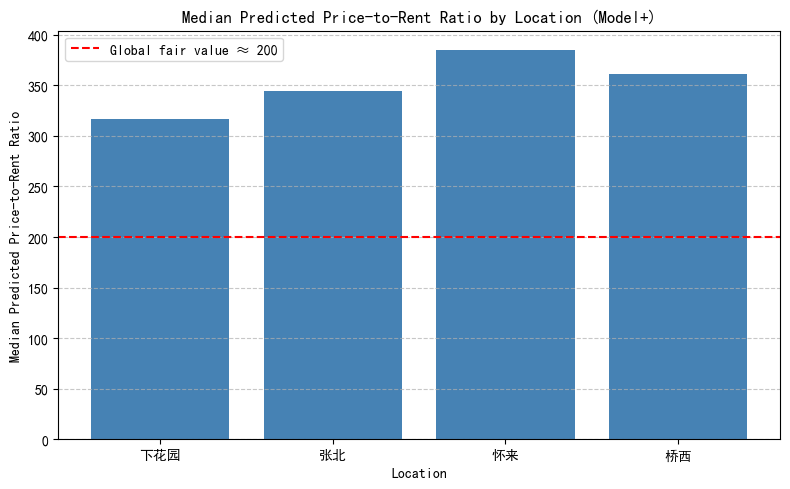


Comparison of Price-to-Rent Ratio by Location (Three Methods):
  location  price_to_rent_simple  price_to_rent_model  \
0      下花园            299.743151           267.600882   
1       张北            363.528244           325.330527   
2       怀来            411.171401           382.093828   
3       桥西            362.144909           329.129139   

   price_to_rent_model_plus  
0                316.298810  
1                343.909719  
2                384.482517  
3                360.581173  


In [16]:
from sklearn.preprocessing import PolynomialFeatures

# 添加非线性特征和交互项
# 使用 m2 的二次项以及 m2 与 location 的交互项
# 先准备数据
df_price_poly = df_price.copy()
df_rent_poly = df_rent.copy()

# 确保 float
df_price_poly['m2'] = df_price_poly['m2'].astype(float)
df_rent_poly['m2'] = df_rent_poly['m2'].astype(float)

# 建立哑变量
df_price_poly = pd.get_dummies(df_price_poly, columns=['location'], drop_first=True).astype(float)
df_rent_poly = pd.get_dummies(df_rent_poly, columns=['location'], drop_first=True).astype(float)

# 获取 location 哑变量列
loc_cols_price = [col for col in df_price_poly.columns if col.startswith('location_')]
loc_cols_rent = [col for col in df_rent_poly.columns if col.startswith('location_')]

# 创建 m2^2
df_price_poly['m2_squared'] = df_price_poly['m2']**2
df_rent_poly['m2_squared'] = df_rent_poly['m2']**2

# 创建交互项: m2 * location
for col in loc_cols_price:
    df_price_poly[f'{col}_x_m2'] = df_price_poly['m2'] * df_price_poly[col]
for col in loc_cols_rent:
    df_rent_poly[f'{col}_x_m2'] = df_rent_poly['m2'] * df_rent_poly[col]

# Model 1+ : price_per_m2 ~ m2 + m2^2 + location + m2*location
X_price_plus = df_price_poly[['m2', 'm2_squared'] + loc_cols_price + [f'{col}_x_m2' for col in loc_cols_price]]
y_price_plus = df_price_poly['price_per_m2']
X_price_plus = sm.add_constant(X_price_plus)
model_price_plus = sm.OLS(y_price_plus, X_price_plus).fit()
print("\nModel 1+ 回归结果：")
print(model_price_plus.summary())

# Model 2+ : rent_per_m2 ~ m2 + m2^2 + location + m2*location
X_rent_plus = df_rent_poly[['m2', 'm2_squared'] + loc_cols_rent + [f'{col}_x_m2' for col in loc_cols_rent]]
y_rent_plus = df_rent_poly['rent_per_m2']
X_rent_plus = sm.add_constant(X_rent_plus)
model_rent_plus = sm.OLS(y_rent_plus, X_rent_plus).fit()
print("\nModel 2+ 回归结果：")
print(model_rent_plus.summary())

# R2 比较
print(f"\nR2 Comparison:")
print(f"Model 1 R2: {model_price.rsquared:.4f}, Model 1+ R2: {model_price_plus.rsquared:.4f}")
print(f"Model 2 R2: {model_rent.rsquared:.4f}, Model 2+ R2: {model_rent_plus.rsquared:.4f}")

# 通常 Model+ 的 R2 会更高，因为增加了非线性和交互项，可以更好拟合数据

# 用 Model+ 预测
df_price['pred_price_per_m2_plus'] = model_price_plus.predict(sm.add_constant(X_price_plus))
df_rent['pred_rent_per_m2_plus'] = model_rent_plus.predict(sm.add_constant(X_rent_plus))

# 合并预测数据，计算价格租金比
df_merged_plus = pd.merge(df_price[['location', 'm2', 'pred_price_per_m2_plus']],
                          df_rent[['location', 'm2', 'pred_rent_per_m2_plus']],
                          on=['location', 'm2'], how='inner')
df_merged_plus['pred_price_to_rent_ratio_plus'] = df_merged_plus['pred_price_per_m2_plus'] / df_merged_plus['pred_rent_per_m2_plus']

# Figure C: 各小区中位数房价租金比柱状图 (Model+) 
median_ratio_block_plus = df_merged_plus.groupby('location')['pred_price_to_rent_ratio_plus'].median().reset_index()

plt.figure(figsize=(8,5))
plt.bar(median_ratio_block_plus['location'], median_ratio_block_plus['pred_price_to_rent_ratio_plus'], color='steelblue')
plt.axhline(y=200, color='r', linestyle='--', label='Global fair value ≈ 200')
plt.title('Median Predicted Price-to-Rent Ratio by Location (Model+)')
plt.xlabel('Location')
plt.ylabel('Median Predicted Price-to-Rent Ratio')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 三种方法房价租金比比较
# 1. 中位数法（Homework3-4）
df_ratio_simple = df_ratio[['location', 'median_price_to_rent_ratio']].copy()
df_ratio_simple.rename(columns={'median_price_to_rent_ratio':'price_to_rent_simple'}, inplace=True)

# 2. Model 1 / Model 2 方法
df_ratio_model = df_merged.groupby('location')['pred_price_to_rent_ratio'].median().reset_index()
df_ratio_model.rename(columns={'pred_price_to_rent_ratio':'price_to_rent_model'}, inplace=True)

# 3. Model+ 方法
df_ratio_model_plus = median_ratio_block_plus.rename(columns={'pred_price_to_rent_ratio_plus':'price_to_rent_model_plus'})

# 合并三种方法
df_compare = df_ratio_simple.merge(df_ratio_model, on='location').merge(df_ratio_model_plus, on='location')
print("\nComparison of Price-to-Rent Ratio by Location (Three Methods):")
print(df_compare)

# 关于信赖度
# 样本量越大越可靠。中位数法只用每个小区的中位数，样本量少，方差大。
# Model 方法用所有样本，但简单线性回归。
# Model+ 用了非线性和交互项，更拟合数据，R2 更高，但可能过拟合。
# 综合考虑，若样本量大，Model+ 可以信赖；样本量小，中位数法可能比较稳健。